#Identifying Trends In The Newspaper's Publications

### Thought Process
What do we talk about when we talk about trends? We can think of two interpretations:
- The straightforward side: What topics is the newspaper publishing about, when and in what volume?
- The hidden side: In what way does the newspaper publishes about a topic? I.e. in what context, with which semantics and with what tone?
  - For example, Israel has a "war-zone" image to some foreigners because they hear about it in the context of conflicts, war and terror.

We will start with tackling the first. To answer these questions, we first need to identify articles talking about specific news subjects. We know from the story-finding part that we need better tools to successfuly do that, and we know in general that it's better to start small.

Therefore, *we suggest the following process:*

1. Select a general topic
2. Select all of the articles about that topic and segment them to more specific and interesting subjects **(using topic modeling)**
3. Visualize the subjects, the when and the volume
4. Look for trends

It's also better to start with a familiar topic, so we chose the Trump presidency (Yuval watches a lot of Stephen Colbert during exam periods...).


## Initialization & Preprocessing
We took all of the articles from June 2015 (when Trump announced his candidacy for president) to date, that had the keyword 'Trump, Donald J'. For each article, we used all the textual metadata: headline, snippet/abstract/lead paragraph, keywords.

In [0]:
# First: Imports & Initialization
##########################################

# Imports
!pip install --upgrade pandas
!python -m spacy download en
!pip install colorcet
!pip install --upgrade seaborn

# Google Colab
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/My Drive/3rd Year/Intro to Data Science/Project/submission')

# General
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import pickle
import datetime
from collections import Counter

# Sklearn
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV

# SpaCy
import spacy
nlp = spacy.load('en')

# PyPlot
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
plt.style.use('seaborn-notebook')


# Helpful visualization functions
def get_model_topics(model, vectorizer, num_topics=30, n_top_words=20):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = vectorizer.get_feature_names()
    
    word_dict = {}
    for i in range(num_topics):
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words
    return pd.DataFrame(word_dict)

  
def print_model_topics(model, vectorizer, num_topics=30, n_top_words=20):
    
    df = get_model_topics(model, vectorizer, num_topics, n_top_words)
    print(df.iloc[:, :20])
    print(df.iloc[:, 20:])

Requirement already up-to-date: pandas in /usr/local/lib/python3.6/dist-packages (0.24.1)

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

Requirement already up-to-date: seaborn in /usr/local/lib/python3.6/dist-packages (0.9.0)
Mounted at /content/drive


In [0]:
# Get the data (after some basic preprocessing: exploding nested fields and removing non-relevant ones)
df = pd.read_pickle('files/3_trends/trump_range_df.pkl')

# Choose subject & create text feature
trump_df = df[df['keyword'] == 'Trump, Donald J']
trump_df['content'] = trump_df['headline'].fillna('') + ' ' + trump_df['headline_print'].fillna('') +\
                      ' ' + trump_df['snippet'].fillna('') + ' ' + trump_df['abstract'].fillna('') +\
                      ' ' + trump_df['lead_paragraph'].fillna('')
trump_df['text'] = trump_df['keywords_all'].str.join(' ') + ' ' + trump_df['content']

# Save
trump_df.to_pickle('files/heavy/trends_data/trump_df.pkl')
# trump_df = pd.read_pickle('files/heavy/trends_data/trump_df.pkl')

# Prepare for Sklearn
i2df_index = trump_df.index
data = list(trump_df['text'].values)

In [0]:
print('Some text samples:')
print(trump_df['text'].sample(5).values)

Some text samples:
['China South Korea International Relations Missiles and Missile Defense Systems Defense and Military Forces United States International Relations Moon Jae-in Trump, Donald J Xi Jinping North Korea China Blinks on South Korea, Making Nice After a Year of Hostilities China Blinks on South Korea, Making Nice After a Year of Hostilities Seoul offered assurances to Beijing as the two papered over their differences on the deployment of an American missile defense system.  '
 'Patient Protection and Affordable Care Act (2010) Health Insurance and Managed Care Republican Party Trump, Donald J New C.B.O. Score: G.O.P. Health Bill Would Save Government Billions but Leave Millions Uninsured  A look at crucial numbers in the Congressional Budget Office report....  A look at crucial numbers in the Congressional Budget Office report.'
 'Muslims and Islam Staten Island (NYC) Presidential Election of 2016 Trump, Donald J Muslim Americans ‘I Had a Scary Dream About Donald Trump’: Mu

In [0]:
print('Shape:', trump_df.shape)
print('Columns:', trump_df.columns)

Shape: (20438, 21)
Columns: Index(['_id', 'abstract', 'document_type', 'headline', 'headline_print',
       'keyword', 'keyword_name', 'keywords', 'keywords_all', 'lead_paragraph',
       'news_desk', 'print_page', 'pub_date', 'section_name', 'snippet',
       'source', 'subsection_name', 'type_of_material', 'word_count',
       'content', 'text'],
      dtype='object')


## Topic Modeling
We experimented with Latent Dirichlet Allocation (LDA) which we saw in class, and Non-Negative Matrix Factorization (NMF). LDA worked quite poorly, and we'll soon try to explain why, but NMF worked really well so we didn't try more models.

###General
Preprocessing the text for topic modeling was done with the sklearn's CountVectorizer and TfidfVectorizer - we tokenized the text, removed punctuation and stop-words, ignored frequent words (in the end we used a max-document frequency of 32%, which is quite brutal but worked well) and for TF-IDF also normalized the feature vectors with L2 norm.

After the results we'll discuss the effects of stemming/lemmatizing and extending tokens to include n-grams.

In [0]:
# Preprocessing
NUM_TOPICS = 35

stopwords = nlp.Defaults.stop_words
stopwords |= {'mr', 'mrs', 'inc', 'iii'}
tfidf_vectorizer = TfidfVectorizer(min_df=25, max_df=0.32, max_features=100000, norm='l2', stop_words=stopwords,
                             ngram_range=(1, 1))
count_vectorizer = CountVectorizer(min_df=25, max_df=0.32, max_features=100000, stop_words=stopwords,
                                   ngram_range=(1, 1))
data_tfidf = tfidf_vectorizer.fit_transform(data)
data_count = count_vectorizer.fit_transform(data)

## LDA
We show the sklearn implementation, though we tested the Gensim one too.
We used a count vector representation of the articles, as LDA expects to get.

The topics we get from LDA are **badly unintelligible**, as you can see from a quick glance in the following table, that shows the top-defining words for each topic. Even when the first words in a topic were related, after them comes a word that is out of context.

This phenomenon was also evident for a lesser number of topics. But what is the problem? The "documents" we are dealing with are small, and most often than not deal with one specific topic. This doesn't really fit the assumptions or the requirements of a probabilistic model like LDA -  which models a document as a mixture of topics, so that each word is drawn from one of its topics.
- The documents are short, and therefore there are too few observations (only ~20,000) to infer the model's relatively many parameters.
- The model is more complex than the data requires, i.e. we don't really need the topic mixture assumption.

In [0]:
# LDA
lda_model = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online')
lda_model.fit_transform(data_count)
get_model_topics(lda_model, count_vectorizer, NUM_TOPICS, n_top_words=15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 26,Topic # 27,Topic # 28,Topic # 29,Topic # 30,Topic # 31,Topic # 32,Topic # 33,Topic # 34,Topic # 35
0,jobs,public,international,convention,defense,new,elections,cohen,elections,nuclear,...,news,cruz,senate,policy,tax,house,iowa,party,court,war
1,office,polls,trade,help,military,york,2018,economic,leaders,intelligence,...,media,republican,health,way,federal,white,carson,republican,executive,people
2,day,opinion,russia,questions,forces,times,week,economy,officials,deal,...,attacks,ted,care,ed,taxes,america,council,democratic,supreme,end
3,labor,lead,russian,family,foreign,city,business,claims,independent,iran,...,report,south,federal,op,plan,administration,benjamin,republicans,changes,civil
4,travel,shows,world,role,sessions,real,refugees,ethics,ryan,relations,...,veterans,john,law,david,bill,representatives,key,paul,readers,press
5,good,university,china,race,speech,order,won,past,jr,international,...,likely,mike,investigation,column,industry,elections,scott,national,appointments,judge
6,staff,face,obama,interest,policy,manhattan,inquiry,working,lawyer,sanctions,...,question,senator,act,message,financial,social,test,time,kavanaugh,million
7,expected,recent,relations,conflicts,flynn,home,nation,finance,victory,weapons,...,story,sanders,washington,life,agency,secretary,voter,manafort,reader,decision
8,work,poll,ties,isn,visit,ohio,displaced,class,fire,night,...,faces,pence,congress,stop,budget,2020,truth,campaign,called,crimes
9,returns,ahead,market,like,jefferson,estate,persons,democracy,vs,israel,...,percent,candidates,bureau,supporters,days,companies,wrong,candidate,brett,response


## NMF
After some online reading about topic modeling, we saw quite a few blog posts about NMF giving better results than LDA on short texts. In essence, NMF takes a non-negative matrix V and approximately factorizes it to two non-negative matrices, V=WH. We can choose one of the dimension of W and H, and so it can be used for dimensionality reduction, or in our case topic modeling (that dimension would be the number of topics).

It is claimed to be equivalent to pLSA, Probabilistic Latent Semantic Analysis, which is sort of a private case of LDA with more constraints - and that means less parameters and a less complex model.

Empirically, at first it seems it gives a very obvious (and coherent, and helpful!) division to topics, which is already a great result. But it is interesting to note that when asking for a higher number of topics, NMF sometimes divides one topic to two finer topics:
- For example, for ~34 topics or less, we will get Saudi Arabia, Israel, Middle East peace & the Khashoggi murder as one topic, or not get them at all (which almost makes sense, as Saudi Arabia is somewhat involved in Israeli-Palestinian peace efforts), but for 35 or higher, Middle East peace & Israel and Saudi Arabia are split to two topics.
- It divided different aspects of the 2016 elections to different topics as the number of topics grew: First there was one general topic, then it split it to the elections for the republican candidate and the general elections (between Trump, Hillary, Sanders).

A few of the topics suggested by NMF are very coherent or very interesting, but because the algorithm is pretty much deterministic, increasing the number of topics doesn't hurt the strong & clear topics that we wished for, and sometimes adds interesting new topics (like Middle Ease peace & Israel).



In [0]:
# Obtain & fit a NMF model.
nmf_model = NMF(n_components=NUM_TOPICS, init='nndsvd')
nmf_model.fit(data_tfidf)

get_model_topics(nmf_model, tfidf_vectorizer, NUM_TOPICS, n_top_words=15)

,Topic # 01,Topic # 02,Topic # 03,Topic # 04,Topic # 05,Topic # 06,Topic # 07,Topic # 08,Topic # 09,Topic # 10,...,Topic # 26,Topic # 27,Topic # 28,Topic # 29,Topic # 30,Topic # 31,Topic # 32,Topic # 33,Topic # 34,Topic # 35
0,party,korea,mueller,care,trade,immigration,clinton,news,tax,colbert,...,sessions,israel,bush,border,ban,economy,pence,saudi,ryan,national
1,republican,north,counsel,health,world,emigration,hillary,media,taxes,tv,...,justice,jerusalem,debate,wall,refugees,jobs,mike,arabia,paul,convention
2,republicans,kim,special,affordable,market,illegal,rodham,fox,federal,program,...,department,palestinians,jeb,mexico,travel,labor,vice,khashoggi,jr,security
3,democratic,jong,robert,act,international,immigrants,sanders,social,income,stephen,...,general,state,political,barriers,executive,economic,running,salman,speaker,gun
4,nominee,un,russian,insurance,tariff,children,campaign,press,cuts,jimmy,...,attorney,netanyahu,candidates,shutdown,orders,growth,mate,jamal,manafort,protests
5,candidate,nuclear,interference,managed,tariffs,childhood,voters,twitter,plan,late,...,jefferson,relations,debates,shutdowns,memorandums,workers,presidency,bin,house,football
6,convention,south,prosecutors,patient,customs,detention,democratic,cnn,corporate,meyers,...,jeff,israeli,rubio,institutional,displaced,federal,presidents,mohammed,campaign,intelligence
7,voters,weapons,ties,2010,war,deportation,polls,channel,deductions,noah,...,attorneys,international,marco,patrol,persons,financial,indiana,assassinations,representatives,anthem
8,nomination,korean,associates,protection,canada,families,debate,fake,credits,seth,...,rosenstein,embassy,george,illegal,order,reserve,pompeo,1985,gates,committee
9,ed,relations,independent,obamacare,american,migrant,bernie,facebook,exemptions,trevor,...,dept,benjamin,john,mexican,muslim,manufacturing,kaine,rights,zinke,adviser


In [0]:
# For mapping the topics:
print_model_topics(nmf_model, tfidf_vectorizer, NUM_TOPICS, n_top_words=15)

## Some Comments
### Choosing the number of topics
Usually in this stage we would devise a scoring function and choose the number of topics by the number that maximizes the score. In topic modeling, we would look at a topic coherence score - which is a measure of the probability that each pair of words in a specific topic are likely to appear together in a document or some window of words in a corpus.

We looked into this aspect, and initially thought about scoring the model with a topic coherence score inferred from a word2vec model trained on wikipedia (as an exterior measure). But then as we saw the determinstic character of NMF and the creation of new topics, we thought it would be better to pick it manually. If we were looking for general topics, or ones that we know less about, it would have been better to choose by scores.

### N-grams & Lemmatization
We also tried running NMF with n-grams and lemmatization (with NLTK's Snowball Stemmer and SpaCy's lemmatizer), but it had no real effect on the topics themselves (just on the words that they were represented by and the words' order), and made the topic model messier, so we decided to drop it. 

## Naming The Topics
Now that we have our topics, we can name them using the top-ranking words for each topic. We left some of the less coherent/interesting topics out, so that some articles might not be mapped to a topic and will be discarded.

In [0]:
# Map topics

# Topic index to topic name:
i2topic = dict()
for i in range(-1, NUM_TOPICS):
    i2topic[i] = 'None'
i2topic[29] = 'Travel Ban'
i2topic[6] = '2016 Elections'
i2topic[5] = 'Immigration'
i2topic[28] = 'US-Mexico Wall'
i2topic[7] = 'Trump\'s Relationship with the Press'
i2topic[14] = 'Climate Change'
i2topic[8] = i2topic[30] = 'US Economy'
i2topic[4] = 'Trade Wars'
i2topic[3] = 'Health Care'
i2topic[2] = i2topic[13] = i2topic[18] = 'Russia Probe'
i2topic[1] = 'North Korea Deal'
i2topic[16] = i2topic[22] = i2topic[25] = 'White House Staff & Personal Counsels'
i2topic[17] = 'Iran Deal'
i2topic[19] = 'Women\'s Rights'
i2topic[26] = 'Israel & Middle East Peace'
i2topic[10] = 'US Military Intervention in The Middle East'
i2topic[24] = 'Midterms'
i2topic[12] = 'Trump\'s Supreme Court Nominees'

topics = [
    '2016 Elections',
    'Women\'s Rights',
    'US Economy',
    'Trump\'s Relationship with the Press',
    'Immigration',
    'Health Care',
    'Israel & Middle East Peace',
    'Russia Probe',
    'Travel Ban',
    'Climate Change',
    'White House Staff & Personal Counsels',
    'Trump\'s Supreme Court Nominees',
    'US Military Intervention in The Middle East',
    'Trade Wars',
    'Iran Deal',
    'North Korea Deal',
    'Midterms',
    'US-Mexico Wall'
]


## Mapping The Documents to Topics
Now that we have our topics, we can tag each of the documents with it's most relevant topic.
As seen below, each document gets a score for belonging to each of topics.

If the maximal score a document gets in any of the topics is still low, then that document doesn't clearly belong to any of the topics, and it's better not to tag it. For that reason, we set a minimum threshold for belonging to a topic, chosen empirically.

In [0]:
# Create Document - Topic Matrix
nmf_output = nmf_model.transform(data_tfidf)
num_articles = len(data)

# column names
topicnames = ["Topic" + str(i) for i in range(1, NUM_TOPICS+1)]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(nmf_output, 3), columns=topicnames)
df_document_topic.index = i2df_index

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
dominant_topic_score = np.max(df_document_topic.values, axis=1)
dominant_topic_score = dominant_topic_score < 0.04
dominant_topic[dominant_topic_score] = -1  # -1 == no topic tag
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic['dominant_topic'] = df_document_topic['dominant_topic'].map(i2topic)

# # Saving new mapping
# trump_df['topic'] = df_document_topic['dominant_topic']
# trump_df.to_pickle('files/heavy/trends_data/trump_df_with_topics.pkl')

# Opening previous mapping
trump_df = pd.read_pickle('files/heavy/trends_data/trump_df_with_topics.pkl')
df_document_topic['dominant_topic'] = trump_df['topic']


# Styling
def color_green(val):
    if type(val) == str:
      if val != 'None':
        color = 'green'
      else:
        color = 'black'
    elif val >= .04:
      color = 'green'
    else:
      color = 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    if type(val) == str:
      if val != 'None':
        weight = 700
      else:
        weight = 400
    elif val >= .04:
      weight = 700
    else:
      weight = 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.sample(20).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,Topic20,Topic21,Topic22,Topic23,Topic24,Topic25,Topic26,Topic27,Topic28,Topic29,Topic30,Topic31,Topic32,Topic33,Topic34,Topic35,dominant_topic
45353,0,0,0,0,0,0.001,0.032,0.001,0,0,0,0,0,0,0.002,0.004,0.002,0.001,0,0.006,0,0.001,0,0.001,0.001,0,0,0.046,0,0,0.004,0,0,0,0,None
824737,0,0,0,0,0,0.053,0,0,0.005,0,0.011,0,0,0,0,0.056,0,0,0,0,0.003,0,0,0,0,0,0,0,0,0.011,0,0,0.001,0,0,None
1133548,0,0,0.001,0,0,0,0,0.035,0,0.001,0,0.002,0,0,0,0,0.009,0.016,0,0.001,0.001,0.011,0.001,0.001,0,0,0.01,0.004,0.019,0,0.005,0.003,0.003,0,0.001,None
325293,0.021,0,0.001,0,0,0.001,0.002,0.001,0,0,0,0,0,0,0,0.001,0,0,0.001,0.002,0,0,0,0,0.004,0,0.001,0.014,0,0.001,0.004,0.001,0,0,0,None
848674,0,0,0,0,0,0,0,0.104,0,0.023,0,0,0,0,0,0.042,0,0,0.005,0.001,0,0,0,0,0,0,0,0,0,0,0.015,0,0,0,0,Trump's Relationship with the Press
1058332,0,0,0,0.044,0,0.023,0,0,0,0.001,0,0,0,0,0.028,0,0,0,0,0,0.004,0,0,0,0,0,0,0,0.002,0,0.01,0.001,0,0,0,Health Care
556617,0,0.057,0,0,0.001,0,0.002,0,0,0,0.005,0.008,0,0,0,0.002,0,0,0,0.001,0,0,0,0,0.005,0.003,0.005,0.004,0,0.002,0.001,0,0,0,0,North Korea Deal
375501,0,0,0,0,0.053,0.007,0.002,0,0,0,0.057,0,0,0.001,0,0.001,0,0.003,0,0,0.004,0,0,0.004,0.001,0,0.028,0.007,0,0,0.005,0.001,0.008,0.001,0.004,US Military Intervention in The Middle East
474253,0,0,0,0,0.001,0,0.067,0,0.001,0.001,0,0.002,0.018,0,0,0,0,0,0,0,0.001,0,0.006,0,0.005,0,0,0,0,0,0,0.088,0,0.003,0.001,None
623623,0,0,0,0,0.002,0,0.001,0.002,0,0,0,0.001,0,0,0.001,0.004,0,0.002,0,0.009,0,0,0,0,0,0,0.017,0,0,0.004,0,0,0,0.001,0.015,None


Number of articles without a topic: 9650 



/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


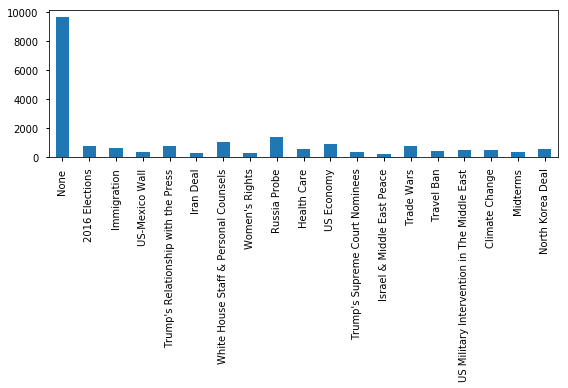

In [0]:
print('Number of articles without a topic:', np.sum(trump_df['topic'] == 'None'), '\n')
# See if the classification's distribution makes sense
histogram = pd.DataFrame.from_dict(Counter(df_document_topic['dominant_topic'].values), orient='index')
histogram.plot(kind='bar', legend=False)

## Visualization
We wanted to visualize the data in a way that would emphasize the trends, so we looked for some inspiration online and then experimented with the following two plots.
### Stacked Area Chart
We extracted the counts for each topic at a weekly frequency and plotted it as a stacked area chart.
It didn't work well as the plot was hard to read because of the number of topics and the sometimes-conflicting trends. It could work better when looking at less topics, and when the trends are very clear.

#### Note
We used D3 to build an iteractive plot but didn't succeed to add it to the notebook for various reasons, so we're only adding a screenshot.

In [0]:
# First, tried stacked area chart

def stacked_topics_area(df, percent=False):
    df['week'] = df['pub_date'].values.astype('datetime64[W]')
    weekly = df[['week', 'topic']]
    weekly = weekly.groupby([weekly['week'], weekly['topic']])['week'].count()
    weekly = weekly.unstack(level=0).fillna(0)
    if percent:
        weekly = weekly.divide(weekly.sum(axis=0), axis=1).T
    else:
        weekly = weekly.T
    return weekly

weekly = stacked_topics_area(trump_df[trump_df['topic'] != 'None'])
weekly.to_csv('files/heavy/trends_data/trump_stacked.csv')

weekly_percent = stacked_topics_area(trump_df[trump_df['topic'] != 'None'], percent=True)
weekly_percent.to_csv('files/heavy/trends_data/trump_stacked_percent.csv')

/usr/local/lib/python3.6/dist-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


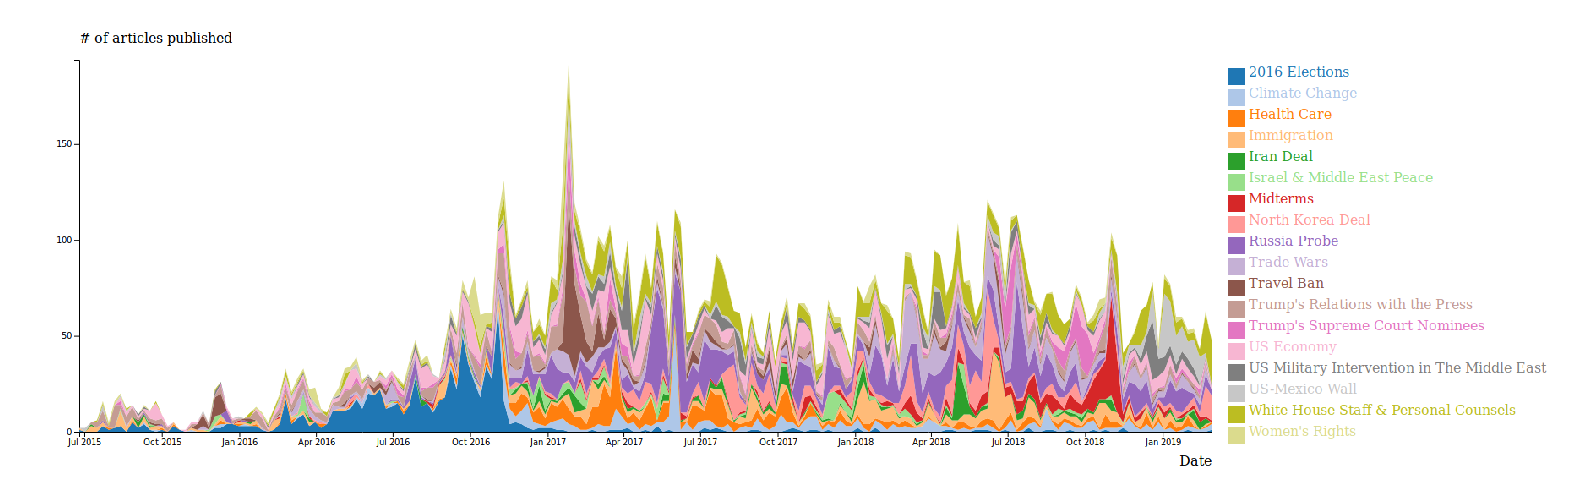

In [0]:
# from IPython.display import display, HTML
# HTML(filename='files/3_trends/stacked_area_chart.html')
import matplotlib.image as mpimg
img=mpimg.imread('files/3_trends/stacked_chart.png')
plt.figure(figsize=(22, 15))
imgplot = plt.imshow(img)
plt.axis('off')
plt.show()


## Ridge Plot

In [0]:
# Next, tried ridge plot

from math import pi
import datetime
toordinal = datetime.date.toordinal

trump_df['week'] = trump_df['pub_date'].values.astype('datetime64[W]')
trump_df['ordinal'] = [x.toordinal() for x in trump_df.week]
ridge_data = trump_df[['week', 'ordinal', 'topic']][trump_df['topic'] != 'None']

from numpy import linspace
from scipy.stats.kde import gaussian_kde

from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, FixedTicker, SingleIntervalTicker, DaysTicker, PrintfTickFormatter, LinearColorMapper
from bokeh.plotting import figure
import colorcet as cc

def ridge(category, data, scale=110):
    return list(zip([category]*len(data), scale*data))

cats = list(reversed(topics))
palette = [cc.rainbow[i*(len(cc.rainbow)//len(cats))] for i in range(len(cats))]

start_t = pd.Timestamp('2015-06-10')
end_t = pd.Timestamp('2019-03-10')
start = start_t.toordinal()
end = end_t.toordinal()
x_t = pd.date_range(start_t, end_t, freq='W')
x = linspace(start, end, len(x_t))
source = ColumnDataSource(data=dict(x=x))

p = figure(y_range=cats, plot_width=1000, x_range=(start, end),x_axis_type = 'datetime', toolbar_location='left',
           tools='wheel_zoom, pan, reset',  active_scroll='wheel_zoom')

for i, cat in enumerate(cats):
    pdf = gaussian_kde(ridge_data[ridge_data['topic'] == cat]['ordinal'], bw_method=0.029)
    y = ridge(cat, pdf(x))
    source.add(y, cat)
    p.patch('x', cat, color=palette[i], alpha=0.6, line_color="black", source=source)

p.outline_line_color = None
p.background_fill_color = "#efefef"

# x axis ticks
ticks_t = pd.date_range(start_t, end_t, freq='MS')
ticks = [t.toordinal() for t in ticks_t]
ticks_dict = {}
for i, tick in enumerate(ticks_t):
  ticks_dict[ticks[i]] = tick.strftime('%b')
  if ticks_dict[ticks[i]] == 'Jan':
      ticks_dict[ticks[i]] = tick.strftime('%Y')
p.xaxis.ticker = FixedTicker(ticks=ticks[::2])
p.xaxis.major_label_overrides = ticks_dict
p.xaxis.axis_label_text_font_size = "20pt"
# p.xaxis.major_label_orientation = pi/4


p.ygrid.grid_line_color = None
p.xgrid.grid_line_color = "#dddddd"
p.xgrid.ticker = p.xaxis[0].ticker

p.axis.minor_tick_line_color = None
p.axis.major_tick_line_color = None
p.axis.axis_line_color = None

p.y_range.range_padding = 0.12

output_notebook()
show(p)

Loading BokehJS ...

This visualization is a lot clearer, and sorting the categories by their density (manually) helps clear things out. The plot certainly answers the straightforward questions: What topics is the newspaper publishing about, when and in what volume?

There are a few things to learn from this plot:
- The NYT "calmed down" about , or "got used to", two issues with Trump:
  - His relationship with the press ('fake news')
  - His misogyny/sexism/you-name-it
- It is also interesting to see that his statement on Jerusalem from December 2017 (when he announced of moving the embassy to Jerusalem) caused as much noise as many other internal US affairs.
- It is also nice to see how "planned events" like elections have such a build-up and a peak and then dry out quickly, while unexpected events form a sudden peak and then slowly decay.

## The Hidden Sense
At the beggining of this section we mentioned "the hidden side": In what way does the newspaper publishes about a topic? I.e. in what context, with which semantics and with what tone?

Unfortunately for us, we didn't get to implement our plans for this part, but we do have a general idea. We'll explain it using a specific subject.
### A Plan: Minorities in the US
For each minority group in the US (African Americans, LGBTQ, Hispanics, Asians, Jews, Arabs, etc.) we will:
1. Select articles related to that group from way back to date.
2. "Augment" the textual data with semantic frames (using FrameNet)
3. Perform topic modeling, looking for contexts and ways that the minority group is mentioned in the NYT.
  - For example, African Americans are recently reported about mostly concerning police violence, riots, demonstrations or female empowerment
  - LGBTQ are probably mentioned a lot in the context of culture and civil rights 
  - This one might actually work better with LDA because we're searching for more general & very different topics, and there would be more data
4. Visualize the findings as a ridge plot per minority group.

It would be interesting to see if the contexts that these groups are mentioned in have change over the last century and how. The semantic augmentation is supposed to find semantic generalizations of the words the NYT uses when concerning a specific minority group. It might be interesting to just count and report the most frequent semantic frames for each group.
